In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import fitsio

from astropy.table import Table

import sys
#sys.path.insert(0, '/home/aew492/lss-dipoles')
sys.path.insert(0, '/Users/ksf/code/nyu/research/lss-dipoles')

#sys.path.insert(0, '../lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

sys.path.insert(0, '/Users/ksf/code/nyu/research/gaia-quasars-lss/code')
import selection_function_map as sfm

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# healpix resolution
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

In [42]:
# Quaia

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False,
                    mask_fn='../../quasar_data_abby/catalogs/masks/mask_master_hpx_r1.0.fits',
                    basedir='../../quasar_data_abby/catalogs')
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# and load selection function
selfunc = d.load_selfunc()

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
map_quaia = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

loading initial catalog, quaia_G20.0.fits


755850 sources in initial catalog.


In [28]:
tab_gcat = Table.read('../../gaia-quasars-lss/data/quaia_G20.0.fits')
fn_sel = '../../gaia-quasars-lss/data/selection_function_NSIDE64_G20.0.fits'
map_sel = hp.read_map(fn_sel)


In [29]:
pixel_indices_gcat = hp.ang2pix(NSIDE, tab_gcat['ra'], tab_gcat['dec'], lonlat=True)
map_gcat = np.bincount(pixel_indices_gcat, minlength=NPIX)

In [14]:
# ecliptic latitudes of each HEALPIXEL
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
# gal_plane_mask = np.zeros_like(datamap)
# gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

In [17]:
idx_nonzero = map_sel > 0

[ 0.03971989 20.46833413]


Text(0, 0.5, 'quaia number of sources')

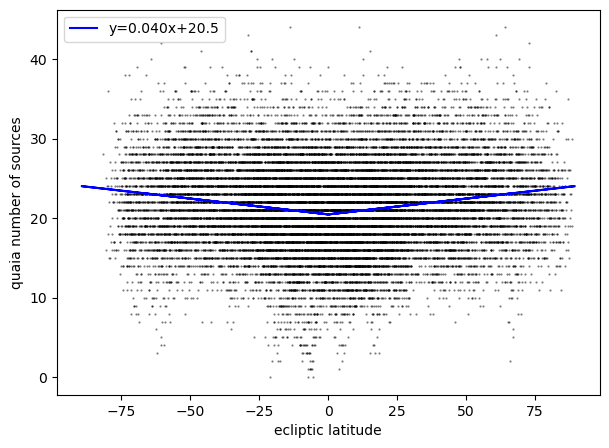

In [46]:
plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia)
p = np.polyfit(np.abs(elat)[idx], map_quaia[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_quaia[idx], s=0.3, c='k', alpha=0.5)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("quaia number of sources")

[0.00121931 0.60734639]


Text(0, 0.5, 'selection function value')

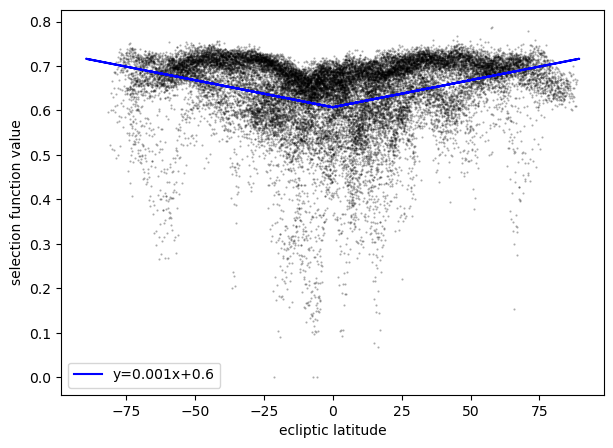

In [52]:
map_sel_masked = np.multiply(map_sel, mask, where=(mask!=0), out=np.full_like(map_sel, np.nan))

plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_sel_masked)
p = np.polyfit(np.abs(elat)[idx], map_sel_masked[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_sel_masked[idx], s=0.3, c='k', alpha=0.3)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("selection function value")

In [59]:
f_dict = {'dust': sfm.f_dust,
             'stars': sfm.f_stars,
             'm10': sfm.f_m10,
             'mcs': sfm.f_mcs,
             'unwise': sfm.f_unwise,
             'unwisescan': sfm.f_unwisescan,
             'mcsunwise': sfm.f_mcsunwise,
             }

In [64]:
#template_names = ['dust', 'stars', 'unwise', 'm10', 'unwisescan', 'mcs', 'mcsunwise']
template_names = ['dust', 'stars', 'unwise', 'm10', 'unwisescan']


[-0.00173584  0.1732939 ]
[-4.19542427e-05  2.87372813e+00]
[0.00727969 4.51787203]
[1.96949118e-03 2.09964209e+01]
[0.01343763 4.59564444]


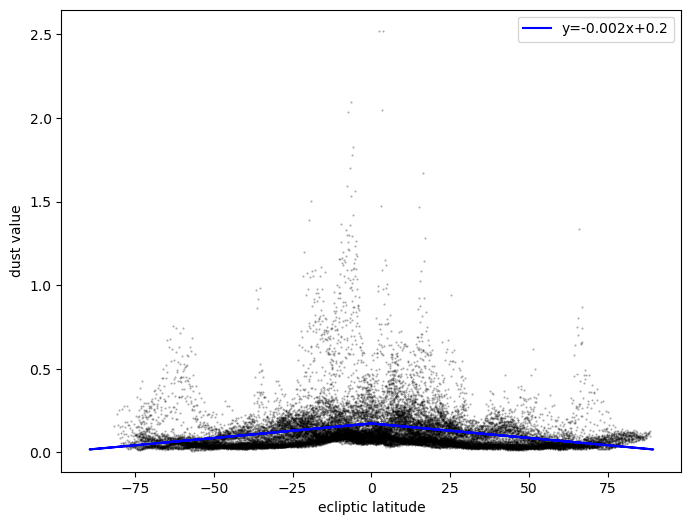

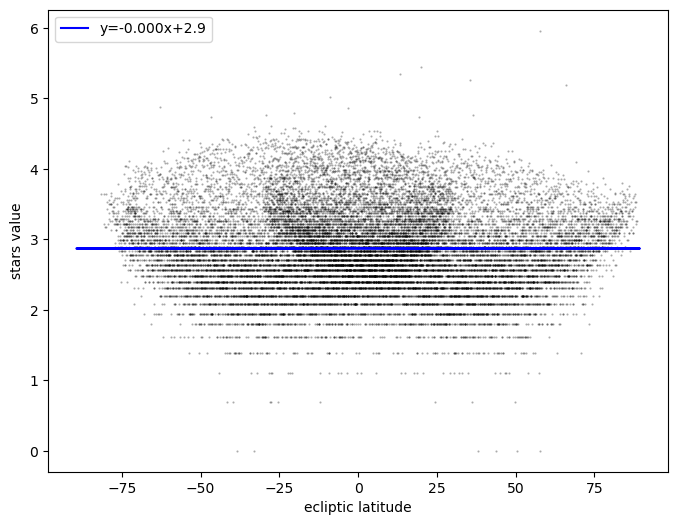

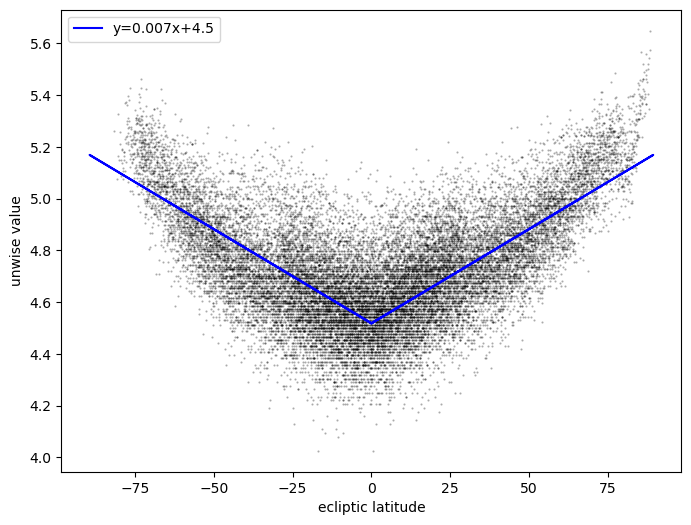

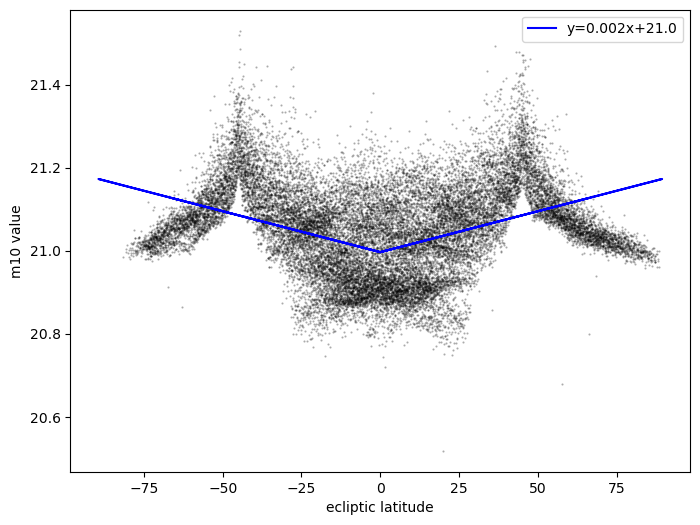

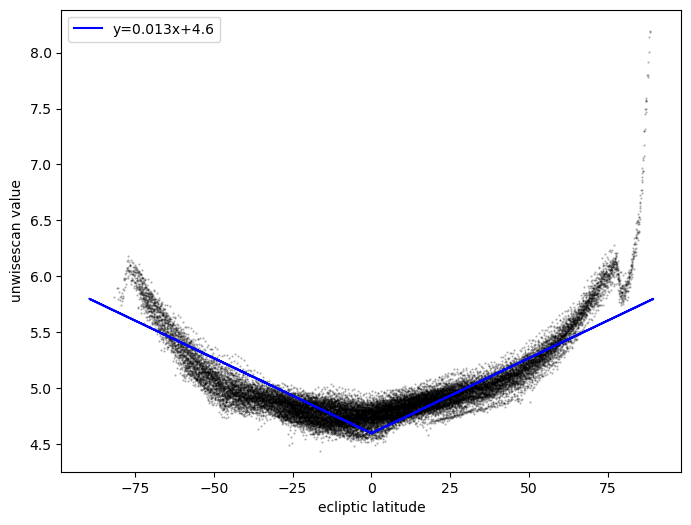

In [66]:
dir_templates = '../../gaia-quasars-lss/data/selection_function_template_maps'

for template_name in template_names:
    
    map_seltemp = np.load(f'{dir_templates}/map_{template_name}_NSIDE{NSIDE}.npy')
    
    map_seltemp_masked = np.multiply(map_seltemp, mask, where=(mask!=0), out=np.full_like(map_seltemp, np.nan))

    # apply same function as in sf fit
    map_seltemp_masked = f_dict[template_name](map_seltemp_masked)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    # fit
    idx = ~np.isnan(elat) & ~np.isnan(map_seltemp_masked)
    p = np.polyfit(np.abs(elat)[idx], map_seltemp_masked[idx], deg=1)
    print(p)

    plt.scatter(elat[idx], map_seltemp_masked[idx], s=0.3, c='k', alpha=0.3)

    ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
    # below the plane
    ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

    plt.legend()
    plt.xlabel("ecliptic latitude")
    plt.ylabel(f"{template_name} value")